In [1]:
import os
import csv
import logging
import random
import sys
import numpy as np
import requests
from random import shuffle
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

from pathlib import Path
from urllib.parse import urlparse
import math



class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines
        
class PgProcessor(DataProcessor):
    """Processor for the PG data set."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]
        
    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

def accuracy_7(out, labels):
    return np.sum(np.round(out) == np.round(labels)) / float(len(labels))

def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        # label_id = label_map[example.label]
        label_id = example.label
        label_id = float(label_id)
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %s)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop(0) #For dialogue context
        else:
            tokens_b.pop()


def accuracy(out, labels):
    num = 0
    for i in range(len(out)):
        if out[i]>=0 and labels[i]>=0:
            num = num+1
        else:
            if out[i]<0 and labels[i]<0:
                num = num+1
    return num


# def accuracy(out, labels):
#     outputs = np.argmax(out, axis=1)
#     return np.sum(outputs == labels)


def F1_score(out):
    outputs = np.argmax(out, axis=1)
    return outputs

def pearson(vector1, vector2):
    n = len(vector1)
    #simple sums
    sum1 = sum(float(vector1[i]) for i in range(n))
    sum2 = sum(float(vector2[i]) for i in range(n))
    #sum up the squares
    sum1_pow = sum([pow(v, 2.0) for v in vector1])
    sum2_pow = sum([pow(v, 2.0) for v in vector2])
    #sum up the products
    p_sum = sum([vector1[i]*vector2[i] for i in range(n)])
    #分子num，分母den
    num = p_sum - (sum1*sum2/n)
    den = math.sqrt((sum1_pow-pow(sum1, 2)/n)*(sum2_pow-pow(sum2, 2)/n))
    if den == 0:
        return 0.0
    return num/den



In [2]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HugginFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch BERT model."""

from __future__ import absolute_import, division, print_function, unicode_literals
from pytorch_pretrained_bert.file_utils import cached_path
import copy
import json
import logging
import math
import os
import shutil
import torch.nn.functional as F
import tarfile
import tempfile
import sys
from io import open

import torch
from torch import nn
from torch.nn import CrossEntropyLoss

from utils import *

logger = logging.getLogger(__name__)

PRETRAINED_MODEL_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased.tar.gz",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz",
    'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased.tar.gz",
    'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased.tar.gz",
    'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese.tar.gz",
}
CONFIG_NAME = 'bert_config.json'
WEIGHTS_NAME = 'pytorch_model.bin'
TF_WEIGHTS_NAME = 'model.ckpt'

def load_tf_weights_in_bert(model, tf_checkpoint_path):
    """ Load tf checkpoints in a pytorch model
    """
    try:
        import re
        import numpy as np
        import tensorflow as tf
    except ImportError:
        print("Loading a TensorFlow models in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions.")
        raise
    tf_path = os.path.abspath(tf_checkpoint_path)
    print("Converting TensorFlow checkpoint from {}".format(tf_path))
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []
    for name, shape in init_vars:
        print("Loading TF weight {} with shape {}".format(name, shape))
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array)

    for name, array in zip(names, arrays):
        name = name.split('/')
        # adam_v and adam_m are variables used in AdamWeightDecayOptimizer to calculated m and v
        # which are not required for using pretrained model
        if any(n in ["adam_v", "adam_m"] for n in name):
            print("Skipping {}".format("/".join(name)))
            continue
        pointer = model
        for m_name in name:
            if re.fullmatch(r'[A-Za-z]+_\d+', m_name):
                l = re.split(r'_(\d+)', m_name)
            else:
                l = [m_name]
            if l[0] == 'kernel' or l[0] == 'gamma':
                pointer = getattr(pointer, 'weight')
            elif l[0] == 'output_bias' or l[0] == 'beta':
                pointer = getattr(pointer, 'bias')
            elif l[0] == 'output_weights':
                pointer = getattr(pointer, 'weight')
            else:
                pointer = getattr(pointer, l[0])
            if len(l) >= 2:
                num = int(l[1])
                pointer = pointer[num]
        if m_name[-11:] == '_embeddings':
            pointer = getattr(pointer, 'weight')
        elif m_name == 'kernel':
            array = np.transpose(array)
        try:
            assert pointer.shape == array.shape
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        print("Initialize PyTorch weight {}".format(name))
        pointer.data = torch.from_numpy(array)
    return model

def bi_modal_attention(x, y):
    m1 = torch.matmul(x,y.transpose(-1, -2))
    n1 = nn.Softmax(dim=-1)(m1)
    o1 = torch.matmul(n1,y)
    a1 = torch.mul(o1, x)

    m2 = torch.matmul(y,x.transpose(-1, -2))
    n2 = nn.Softmax(dim=-1)(m2)
    o2 = torch.matmul(n2,x)
    a2 = torch.mul(o2, y)
    return a1,a2

def gelu(x):
    """Implementation of the gelu activation function.
        For information: OpenAI GPT's gelu is slightly different (and gives slightly different results):
        0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        Also see https://arxiv.org/abs/1606.08415
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": gelu, "relu": torch.nn.functional.relu, "swish": swish}


class BertConfig(object):
    """Configuration class to store the configuration of a `BertModel`.
    """
    def __init__(self,
                 vocab_size_or_config_json_file,
                 hidden_size=768,
                 num_hidden_layers=12,
                 num_attention_heads=12,
                 intermediate_size=3072,
                 hidden_act="gelu",
                 hidden_dropout_prob=0.1,
                 attention_probs_dropout_prob=0.1,
                 max_position_embeddings=512,
                 type_vocab_size=2,
                 initializer_range=0.02):
        """Constructs BertConfig.

        Args:
            vocab_size_or_config_json_file: Vocabulary size of `inputs_ids` in `BertModel`.
            hidden_size: Size of the encoder layers and the pooler layer.
            num_hidden_layers: Number of hidden layers in the Transformer encoder.
            num_attention_heads: Number of attention heads for each attention layer in
                the Transformer encoder.
            intermediate_size: The size of the "intermediate" (i.e., feed-forward)
                layer in the Transformer encoder.
            hidden_act: The non-linear activation function (function or string) in the
                encoder and pooler. If string, "gelu", "relu" and "swish" are supported.
            hidden_dropout_prob: The dropout probabilitiy for all fully connected
                layers in the embeddings, encoder, and pooler.
            attention_probs_dropout_prob: The dropout ratio for the attention
                probabilities.
            max_position_embeddings: The maximum sequence length that this model might
                ever be used with. Typically set this to something large just in case
                (e.g., 512 or 1024 or 2048).
            type_vocab_size: The vocabulary size of the `token_type_ids` passed into
                `BertModel`.
            initializer_range: The sttdev of the truncated_normal_initializer for
                initializing all weight matrices.
        """
        if isinstance(vocab_size_or_config_json_file, str) or (sys.version_info[0] == 2
                        and isinstance(vocab_size_or_config_json_file, unicode)):
            with open(vocab_size_or_config_json_file, "r", encoding='utf-8') as reader:
                json_config = json.loads(reader.read())
            for key, value in json_config.items():
                self.__dict__[key] = value
        elif isinstance(vocab_size_or_config_json_file, int):
            self.vocab_size = vocab_size_or_config_json_file
            self.hidden_size = hidden_size
            self.num_hidden_layers = num_hidden_layers
            self.num_attention_heads = num_attention_heads
            self.hidden_act = hidden_act
            self.intermediate_size = intermediate_size
            self.hidden_dropout_prob = hidden_dropout_prob
            self.attention_probs_dropout_prob = attention_probs_dropout_prob
            self.max_position_embeddings = max_position_embeddings
            self.type_vocab_size = type_vocab_size
            self.initializer_range = initializer_range
        else:
            raise ValueError("First argument must be either a vocabulary size (int)"
                             "or the path to a pretrained model config file (str)")

    @classmethod
    def from_dict(cls, json_object):
        """Constructs a `BertConfig` from a Python dictionary of parameters."""
        config = BertConfig(vocab_size_or_config_json_file=-1)
        for key, value in json_object.items():
            config.__dict__[key] = value
        return config

    @classmethod
    def from_json_file(cls, json_file):
        """Constructs a `BertConfig` from a json file of parameters."""
        with open(json_file, "r", encoding='utf-8') as reader:
            text = reader.read()
        return cls.from_dict(json.loads(text))

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

try:
    from apex.normalization.fused_layer_norm import FusedLayerNorm as BertLayerNorm
except ImportError:
    print("Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.")
    class BertLayerNorm(nn.Module):
        def __init__(self, hidden_size, eps=1e-12):
            """Construct a layernorm module in the TF style (epsilon inside the square root).
            """
            super(BertLayerNorm, self).__init__()
            self.weight = nn.Parameter(torch.ones(hidden_size))
            self.bias = nn.Parameter(torch.zeros(hidden_size))
            self.variance_epsilon = eps

        def forward(self, x):
            u = x.mean(-1, keepdim=True)
            s = (x - u).pow(2).mean(-1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.variance_epsilon)
            return self.weight * x + self.bias

class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings.
    """
    def __init__(self, config):
        super(BertEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids,token_type_ids=None):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        #在第一维增加一维，`input_ids`: a torch.LongTensor of shape [batch_size, sequence_length] with the word token indices in the vocabulary
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        #对应paper中segment embeddings 
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        
        embeddings = words_embeddings + position_embeddings + token_type_embeddings 
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


        
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super(BertSelfAttention, self).__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (config.hidden_size, config.num_attention_heads))
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states,audio_data, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer


class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states,input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states



class BertAttention(nn.Module):
    def __init__(self, config):
        super(BertAttention, self).__init__()
        self.self = BertSelfAttention(config)
        self.output = BertSelfOutput(config)

    def forward(self, input_tensor,audio_data,attention_mask):
        self_output = self.self(input_tensor,audio_data,attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output


class BertIntermediate(nn.Module):
    def __init__(self, config):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.intermediate_act_fn = ACT2FN[config.hidden_act]
        else:
            self.intermediate_act_fn = config.hidden_act

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states


class BertOutput(nn.Module):
    def __init__(self, config):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states


class BertLayer(nn.Module):
    def __init__(self, config):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(config)#过一层Multi-Head Attention 然后与input加和过一层Norm层
        self.intermediate = BertIntermediate(config)#过一层Linear然后过gelu激活函数
        self.output = BertOutput(config)#过一层Linear然后过dropout然后与input加和过norm

    def forward(self, hidden_states,all_audio_data,attention_mask):
        attention_output = self.attention(hidden_states,all_audio_data,attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output


        
        
class BertFinetun(nn.Module):
    def __init__(self, config):
        super(BertFinetun, self).__init__()
        self.proj_t = nn.Conv1d(1024,24, kernel_size=1, padding=0, bias=False)
        self.proj_a = nn.Conv1d(5,30, kernel_size=1, padding=0, bias=False)
        self.activation = nn.ReLU()
        self.audio_weight_1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.text_weight_1 = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.bias = torch.nn.Parameter(torch.FloatTensor(1), requires_grad=True)
        self.audio_weight_1.data.fill_(1)
        self.text_weight_1.data.fill_(1)
        self.bias.data.fill_(0)
        self.dropout1 = nn.Dropout(0.3)
        self.dense = nn.Linear(1024, 1024)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm1 = BertLayerNorm(1024)
        
        
    def forward(self, hidden_states,pooled_output,audio_data,attention_mask):
        attention_mask = attention_mask.squeeze(1)
        attention_mask_ = attention_mask.permute(0, 2, 1)
        text_data = hidden_states
        text_data = text_data.transpose(1, 2)
        text_data = self.proj_t(text_data)
        text_data = text_data.transpose(1, 2)
        text_data_1 = text_data.reshape(-1).cpu().detach().numpy()
        weights = np.sqrt(np.linalg.norm(text_data_1,ord=2))
        text_data = text_data/weights

        audio_data = audio_data.transpose(1, 2)
        audio_data = self.proj_a(audio_data)
        audio_data = audio_data.transpose(1, 2)
        

        text_att = torch.matmul(text_data,text_data.transpose(-1, -2))
        text_att1 = self.activation(text_att)

        audio_att = torch.matmul(audio_data,audio_data.transpose(-1, -2))
        audio_att = self.activation(audio_att)

        audio_weight_1 = self.audio_weight_1
        text_weight_1 = self.text_weight_1
        bias = self.bias
        
        fusion_att =text_weight_1*text_att1 + audio_weight_1*audio_att + bias 
        fusion_att1 = self.activation(fusion_att)
        fusion_att = fusion_att+ attention_mask+ attention_mask_
        fusion_att = nn.Softmax(dim=-1)(fusion_att)
        fusion_att = self.dropout1(fusion_att)
        
        fusion_data = torch.matmul(fusion_att,hidden_states)
        fusion_data = fusion_data+hidden_states

        hidden_states_new = self.dense(fusion_data)
        hidden_states_new = self.dropout(hidden_states_new)
        hidden_states_new = self.LayerNorm1(hidden_states_new)
        hidden_states_new = hidden_states_new[:,0]
        return hidden_states_new,text_att1,fusion_att1

        
        


class BertEncoder(nn.Module):
    def __init__(self, config):
        super(BertEncoder, self).__init__()
        layer = BertLayer(config)#Transformer block
        self.layer = nn.ModuleList([copy.deepcopy(layer) for _ in range(config.num_attention_heads)])

    def forward(self, hidden_states,all_audio_data,attention_mask, output_all_encoded_layers=True):
        all_encoder_layers = []
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states,all_audio_data, attention_mask)
            if output_all_encoded_layers:
                all_encoder_layers.append(hidden_states)
        if not output_all_encoded_layers:
            all_encoder_layers.append(hidden_states)
        return all_encoder_layers


class BertPooler(nn.Module):
    def __init__(self, config):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output


class BertPredictionHeadTransform(nn.Module):
    def __init__(self, config):
        super(BertPredictionHeadTransform, self).__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if isinstance(config.hidden_act, str) or (sys.version_info[0] == 2 and isinstance(config.hidden_act, unicode)):
            self.transform_act_fn = ACT2FN[config.hidden_act]
        else:
            self.transform_act_fn = config.hidden_act
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=1e-12)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.transform_act_fn(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states


class BertLMPredictionHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertLMPredictionHead, self).__init__()
        self.transform = BertPredictionHeadTransform(config)

        # The output weights are the same as the input embeddings, but there is
        # an output-only bias for each token.
        self.decoder = nn.Linear(bert_model_embedding_weights.size(1),
                                 bert_model_embedding_weights.size(0),
                                 bias=False)
        self.decoder.weight = bert_model_embedding_weights
        self.bias = nn.Parameter(torch.zeros(bert_model_embedding_weights.size(0)))

    def forward(self, hidden_states):
        hidden_states = self.transform(hidden_states)
        hidden_states = self.decoder(hidden_states) + self.bias
        return hidden_states


class BertOnlyMLMHead(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertOnlyMLMHead, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)

    def forward(self, sequence_output):
        prediction_scores = self.predictions(sequence_output)
        return prediction_scores


class BertOnlyNSPHead(nn.Module):
    def __init__(self, config):
        super(BertOnlyNSPHead, self).__init__()
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, pooled_output):
        seq_relationship_score = self.seq_relationship(pooled_output)
        return seq_relationship_score


class BertPreTrainingHeads(nn.Module):
    def __init__(self, config, bert_model_embedding_weights):
        super(BertPreTrainingHeads, self).__init__()
        self.predictions = BertLMPredictionHead(config, bert_model_embedding_weights)
        self.seq_relationship = nn.Linear(config.hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        prediction_scores = self.predictions(sequence_output)
        seq_relationship_score = self.seq_relationship(pooled_output)
        return prediction_scores, seq_relationship_score


class BertPreTrainedModel(nn.Module):
    """ An abstract class to handle weights initialization and
        a simple interface for dowloading and loading pretrained models.
    """
    def __init__(self, config, *inputs, **kwargs):
        super(BertPreTrainedModel, self).__init__()
        if not isinstance(config, BertConfig):
            raise ValueError(
                "Parameter config in `{}(config)` should be an instance of class `BertConfig`. "
                "To create a model from a Google pretrained model use "
                "`model = {}.from_pretrained(PRETRAINED_MODEL_NAME)`".format(
                    self.__class__.__name__, self.__class__.__name__
                ))
        self.config = config

    def init_bert_weights(self, module):
        """ Initialize the weights.
        """
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        elif isinstance(module, BertLayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, state_dict=None, cache_dir=None,
                        from_tf=False, *inputs, **kwargs):
        """
        Instantiate a BertPreTrainedModel from a pre-trained model file or a pytorch state dict.
        Download and cache the pre-trained model file if needed.

        Params:
            pretrained_model_name_or_path: either:
                - a str with the name of a pre-trained model to load selected in the list of:
                    . `bert-base-uncased`
                    . `bert-large-uncased`
                    . `bert-base-cased`
                    . `bert-large-cased`
                    . `bert-base-multilingual-uncased`
                    . `bert-base-multilingual-cased`
                    . `bert-base-chinese`
                - a path or url to a pretrained model archive containing:
                    . `bert_config.json` a configuration file for the model
                    . `pytorch_model.bin` a PyTorch dump of a BertForPreTraining instance
                - a path or url to a pretrained model archive containing:
                    . `bert_config.json` a configuration file for the model
                    . `model.chkpt` a TensorFlow checkpoint
            from_tf: should we load the weights from a locally saved TensorFlow checkpoint
            cache_dir: an optional path to a folder in which the pre-trained models will be cached.
            state_dict: an optional state dictionnary (collections.OrderedDict object) to use instead of Google pre-trained models
            *inputs, **kwargs: additional input for the specific Bert class
                (ex: num_labels for BertForSequenceClassification)
        """
        if pretrained_model_name_or_path in PRETRAINED_MODEL_ARCHIVE_MAP:
            archive_file = PRETRAINED_MODEL_ARCHIVE_MAP[pretrained_model_name_or_path]
        else:
            archive_file = pretrained_model_name_or_path
        # redirect to the cache, if necessary
        try:
            resolved_archive_file = cached_path(archive_file, cache_dir=cache_dir)
        except EnvironmentError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name_or_path,
                    ', '.join(PRETRAINED_MODEL_ARCHIVE_MAP.keys()),
                    archive_file))
            return None
        if resolved_archive_file == archive_file:
            logger.info("loading archive file {}".format(archive_file))
        else:
            logger.info("loading archive file {} from cache at {}".format(
                archive_file, resolved_archive_file))
        tempdir = None
        if os.path.isdir(resolved_archive_file) or from_tf:
            serialization_dir = resolved_archive_file
        else:
            # Extract archive to temp dir
            tempdir = tempfile.mkdtemp()
            logger.info("extracting archive file {} to temp dir {}".format(
                resolved_archive_file, tempdir))
            with tarfile.open(resolved_archive_file, 'r:gz') as archive:
                archive.extractall(tempdir)
            serialization_dir = tempdir
        # Load config
        config_file = os.path.join(serialization_dir, CONFIG_NAME)
        config = BertConfig.from_json_file(config_file)
        logger.info("Model config {}".format(config))
        # Instantiate model.
        model = cls(config, *inputs, **kwargs)
        if state_dict is None and not from_tf:
            weights_path = os.path.join(serialization_dir, WEIGHTS_NAME)
            state_dict = torch.load(weights_path, map_location='cpu' if not torch.cuda.is_available() else None)
        if tempdir:
            # Clean up temp dir
            shutil.rmtree(tempdir)
        if from_tf:
            # Directly load from a TensorFlow checkpoint
            weights_path = os.path.join(serialization_dir, TF_WEIGHTS_NAME)
            return load_tf_weights_in_bert(model, weights_path)
        # Load from a PyTorch state_dict
        old_keys = []
        new_keys = []
        for key in state_dict.keys():
            new_key = None
            if 'gamma' in key:
                new_key = key.replace('gamma', 'weight')
            if 'beta' in key:
                new_key = key.replace('beta', 'bias')
            if new_key:
                old_keys.append(key)
                new_keys.append(new_key)
        for old_key, new_key in zip(old_keys, new_keys):
            state_dict[new_key] = state_dict.pop(old_key)

        missing_keys = []
        unexpected_keys = []
        error_msgs = []
        # copy state_dict so _load_from_state_dict can modify it
        metadata = getattr(state_dict, '_metadata', None)
        state_dict = state_dict.copy()
        if metadata is not None:
            state_dict._metadata = metadata

        def load(module, prefix=''):
            local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
            module._load_from_state_dict(
                state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
            for name, child in module._modules.items():
                if child is not None:
                    load(child, prefix + name + '.')
        start_prefix = ''
        if not hasattr(model, 'bert') and any(s.startswith('bert.') for s in state_dict.keys()):
            start_prefix = 'bert.'
        load(model, prefix=start_prefix)
        if len(missing_keys) > 0:
            logger.info("Weights of {} not initialized from pretrained model: {}".format(
                model.__class__.__name__, missing_keys))
        if len(unexpected_keys) > 0:
            logger.info("Weights from pretrained model not used in {}: {}".format(
                model.__class__.__name__, unexpected_keys))
        if len(error_msgs) > 0:
            raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
                               model.__class__.__name__, "\n\t".join(error_msgs)))
        return model


class BertModel(BertPreTrainedModel):
    """BERT model ("Bidirectional Embedding Representations from a Transformer").

    Params:
        config: a BertConfig class instance with the configuration to build a new model

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `output_all_encoded_layers`: boolean which controls the content of the `encoded_layers` output as described below. Default: `True`.

    Outputs: Tuple of (encoded_layers, pooled_output)
        `encoded_layers`: controled by `output_all_encoded_layers` argument:
            - `output_all_encoded_layers=True`: outputs a list of the full sequences of encoded-hidden-states at the end
                of each attention block (i.e. 12 full sequences for BERT-base, 24 for BERT-large), each
                encoded-hidden-state is a torch.FloatTensor of size [batch_size, sequence_length, hidden_size],
            - `output_all_encoded_layers=False`: outputs only the full sequence of hidden-states corresponding
                to the last attention block of shape [batch_size, sequence_length, hidden_size],
        `pooled_output`: a torch.FloatTensor of size [batch_size, hidden_size] which is the output of a
            classifier pretrained on top of the hidden state associated to the first character of the
            input (`CLS`) to train on the Next-Sentence task (see BERT's paper).

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = modeling.BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    model = modeling.BertModel(config=config)
    all_encoder_layers, pooled_output = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertModel, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = BertEncoder(config)
        self.pooler = BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids,all_audio_data,token_type_ids=None, attention_mask=None,output_all_encoded_layers=True):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        embedding_output = self.embeddings(input_ids,token_type_ids)
        encoded_layers = self.encoder(embedding_output,
                                      all_audio_data,
                                      extended_attention_mask,
                                      output_all_encoded_layers=output_all_encoded_layers)
        sequence_output = encoded_layers[-1]#选取最后一层Encoder的输出
        pooled_output = self.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]
        return sequence_output, pooled_output,extended_attention_mask


class BertForPreTraining(BertPreTrainedModel):
    """BERT model with pre-training heads.
    This module comprises the BERT model followed by the two pre-training heads:
        - the masked language modeling head, and
        - the next sentence classification head.

    Params:
        config: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `masked_lm_labels`: optional masked language modeling labels: torch.LongTensor of shape [batch_size, sequence_length]
            with indices selected in [-1, 0, ..., vocab_size]. All labels set to -1 are ignored (masked), the loss
            is only computed for the labels set in [0, ..., vocab_size]
        `next_sentence_label`: optional next sentence classification loss: torch.LongTensor of shape [batch_size]
            with indices selected in [0, 1].
            0 => next sentence is the continuation, 1 => next sentence is a random sentence.

    Outputs:
        if `masked_lm_labels` and `next_sentence_label` are not `None`:
            Outputs the total_loss which is the sum of the masked language modeling loss and the next
            sentence classification loss.
        if `masked_lm_labels` or `next_sentence_label` is `None`:
            Outputs a tuple comprising
            - the masked language modeling logits of shape [batch_size, sequence_length, vocab_size], and
            - the next sentence classification logits of shape [batch_size, 2].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    model = BertForPreTraining(config)
    masked_lm_logits_scores, seq_relationship_logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForPreTraining, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertPreTrainingHeads(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None, next_sentence_label=None):
        sequence_output, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                                   output_all_encoded_layers=False)
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)

        if masked_lm_labels is not None and next_sentence_label is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
            total_loss = masked_lm_loss + next_sentence_loss
            return total_loss
        else:
            return prediction_scores, seq_relationship_score


class BertForMaskedLM(BertPreTrainedModel):
    """BERT model with the masked language modeling head.
    This module comprises the BERT model followed by the masked language modeling head.

    Params:
        config: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `masked_lm_labels`: masked language modeling labels: torch.LongTensor of shape [batch_size, sequence_length]
            with indices selected in [-1, 0, ..., vocab_size]. All labels set to -1 are ignored (masked), the loss
            is only computed for the labels set in [0, ..., vocab_size]

    Outputs:
        if `masked_lm_labels` is  not `None`:
            Outputs the masked language modeling loss.
        if `masked_lm_labels` is `None`:
            Outputs the masked language modeling logits of shape [batch_size, sequence_length, vocab_size].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    model = BertForMaskedLM(config)
    masked_lm_logits_scores = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForMaskedLM, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertOnlyMLMHead(config, self.bert.embeddings.word_embeddings.weight)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, masked_lm_labels=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask,
                                       output_all_encoded_layers=False)
        prediction_scores = self.cls(sequence_output)

        if masked_lm_labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), masked_lm_labels.view(-1))
            return masked_lm_loss
        else:
            return prediction_scores


class BertForNextSentencePrediction(BertPreTrainedModel):
    """BERT model with next sentence prediction head.
    This module comprises the BERT model followed by the next sentence classification head.

    Params:
        config: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `next_sentence_label`: next sentence classification loss: torch.LongTensor of shape [batch_size]
            with indices selected in [0, 1].
            0 => next sentence is the continuation, 1 => next sentence is a random sentence.

    Outputs:
        if `next_sentence_label` is not `None`:
            Outputs the total_loss which is the sum of the masked language modeling loss and the next
            sentence classification loss.
        if `next_sentence_label` is `None`:
            Outputs the next sentence classification logits of shape [batch_size, 2].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    model = BertForNextSentencePrediction(config)
    seq_relationship_logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForNextSentencePrediction, self).__init__(config)
        self.bert = BertModel(config)
        self.cls = BertOnlyNSPHead(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, next_sentence_label=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask,
                                     output_all_encoded_layers=False)
        seq_relationship_score = self.cls( pooled_output)

        if next_sentence_label is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-1)
            next_sentence_loss = loss_fct(seq_relationship_score.view(-1, 2), next_sentence_label.view(-1))
            return next_sentence_loss
        else:
            return seq_relationship_score


class BertForSequenceClassification(BertPreTrainedModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_labels].

    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    num_labels = 2

    model = BertForSequenceClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, num_labels):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.BertFinetun = BertFinetun(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)#拿出来CLS的表示dimension = 768
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, all_audio_data,token_type_ids=None, attention_mask=None, labels=None):
        encoder_lastoutput, pooled_output, extend_mask = self.bert(input_ids,all_audio_data,token_type_ids, attention_mask, output_all_encoded_layers=True)
        pooled_output = self.dropout(pooled_output)
        pooled_output,text_att,fusion_att = self.BertFinetun(encoder_lastoutput,pooled_output,all_audio_data,extend_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        if labels is not None:
            loss = 0.5 * (logits.view(-1) - labels) ** 2 
            return loss
        else:
            return logits,text_att,fusion_att


class BertForMultipleChoice(BertPreTrainedModel):
    """BERT model for multiple choice tasks.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_choices`: the number of classes for the classifier. Default = 2.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, num_choices, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, num_choices, sequence_length]
            with the token types indices selected in [0, 1]. Type 0 corresponds to a `sentence A`
            and type 1 corresponds to a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, num_choices, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size]
            with indices selected in [0, ..., num_choices].

    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, num_labels].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[[31, 51, 99], [15, 5, 0]], [[12, 16, 42], [14, 28, 57]]])
    input_mask = torch.LongTensor([[[1, 1, 1], [1, 1, 0]],[[1,1,0], [1, 0, 0]]])
    token_type_ids = torch.LongTensor([[[0, 0, 1], [0, 1, 0]],[[0, 1, 1], [0, 0, 1]]])
    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    num_choices = 2

    model = BertForMultipleChoice(config, num_choices)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, num_choices):
        super(BertForMultipleChoice, self).__init__(config)
        self.num_choices = num_choices
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        flat_input_ids = input_ids.view(-1, input_ids.size(-1))
        flat_token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1))
        flat_attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        _, pooled_output = self.bert(flat_input_ids, flat_token_type_ids, flat_attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        reshaped_logits = logits.view(-1, self.num_choices)

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(reshaped_logits, labels)
            return loss
        else:
            return reshaped_logits


class BertForTokenClassification(BertPreTrainedModel):
    """BERT model for token-level classification.
    This module is composed of the BERT model with a linear layer on top of
    the full hidden state of the last layer.

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.
        `num_labels`: the number of classes for the classifier. Default = 2.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `labels`: labels for the classification output: torch.LongTensor of shape [batch_size, sequence_length]
            with indices selected in [0, ..., num_labels].

    Outputs:
        if `labels` is not `None`:
            Outputs the CrossEntropy classification loss of the output with the labels.
        if `labels` is `None`:
            Outputs the classification logits of shape [batch_size, sequence_length, num_labels].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    num_labels = 2

    model = BertForTokenClassification(config, num_labels)
    logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config, num_labels):
        super(BertForTokenClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        else:
            return logits


class BertForQuestionAnswering(BertPreTrainedModel):
    """BERT model for Question Answering (span extraction).
    This module is composed of the BERT model with a linear layer on top of
    the sequence output that computes start_logits and end_logits

    Params:
        `config`: a BertConfig class instance with the configuration to build a new model.

    Inputs:
        `input_ids`: a torch.LongTensor of shape [batch_size, sequence_length]
            with the word token indices in the vocabulary(see the tokens preprocessing logic in the scripts
            `extract_features.py`, `run_classifier.py` and `run_squad.py`)
        `token_type_ids`: an optional torch.LongTensor of shape [batch_size, sequence_length] with the token
            types indices selected in [0, 1]. Type 0 corresponds to a `sentence A` and type 1 corresponds to
            a `sentence B` token (see BERT paper for more details).
        `attention_mask`: an optional torch.LongTensor of shape [batch_size, sequence_length] with indices
            selected in [0, 1]. It's a mask to be used if the input sequence length is smaller than the max
            input sequence length in the current batch. It's the mask that we typically use for attention when
            a batch has varying length sentences.
        `start_positions`: position of the first token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.
        `end_positions`: position of the last token for the labeled span: torch.LongTensor of shape [batch_size].
            Positions are clamped to the length of the sequence and position outside of the sequence are not taken
            into account for computing the loss.

    Outputs:
        if `start_positions` and `end_positions` are not `None`:
            Outputs the total_loss which is the sum of the CrossEntropy loss for the start and end token positions.
        if `start_positions` or `end_positions` is `None`:
            Outputs a tuple of start_logits, end_logits which are the logits respectively for the start and end
            position tokens of shape [batch_size, sequence_length].

    Example usage:
    ```python
    # Already been converted into WordPiece token ids
    input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
    input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
    token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])

    config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)

    model = BertForQuestionAnswering(config)
    start_logits, end_logits = model(input_ids, token_type_ids, input_mask)
    ```
    """
    def __init__(self, config):
        super(BertForQuestionAnswering, self).__init__(config)
        self.bert = BertModel(config)
        # TODO check with Google if it's normal there is no dropout on the token classifier of SQuAD in the TF version
        # self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, start_positions=None, end_positions=None):
        sequence_output, _ = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2
            return total_loss
        else:
            return start_logits, end_logits


06/26/2023 08:39:21 - INFO - pytorch_pretrained_bert.modeling -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
"""BERT finetuning runner."""
from __future__ import absolute_import, division, print_function
import argparse
import os
import shutil
import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from tqdm import tqdm, trange
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE,cached_path
from model import BertForSequenceClassification, BertConfig, WEIGHTS_NAME, CONFIG_NAME
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule
from utils import *
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import metrics
import math
import seaborn as sns
import matplotlib.pyplot as plt

#单GPU
# os.environ["CUDA_VISIBLE_DEVICES"]="1"


"""BERT finetuning runner."""
def main(i):
    logger.info("Line 29: {}".format(torch.cuda.is_available()))
    parser = argparse.ArgumentParser()

    ## Required parameters
    parser.add_argument("-f")
    parser.add_argument("--data_dir", default='C:/Users/anil1/Desktop/CM_BERT_large/data/text', type=str,
                        help="The input data dir. Should contain the .tsv files (or other data files) for the task.")
    parser.add_argument("--bert_model", default='C:/Users/anil1/Desktop/CM_BERT_large/pre_trained_Bert', type=str,
                        help="Bert pre-trained model selected in the list: bert-base-uncased, "
                        "bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, "
                        "bert-base-multilingual-cased, bert-base-chinese.")
    parser.add_argument("--task_name", default='Multi', type=str,
                        help="The name of the task to train.")
    parser.add_argument("--output_dir", default='C:/Users/anil1/Desktop/CM_BERT_large/CM-BERT_output', type=str,
                        help="The output directory where the model predictions and checkpoints will be written.")

    ## Other parameters
    parser.add_argument("--cache_dir", default="", type=str,
                        help="Where do you want to store the pre-trained models downloaded from s3")
    parser.add_argument("--max_seq_length", default=50, type=int,
                        help="The maximum total input sequence length after WordPiece tokenization. \n"
                             "Sequences longer than this will be truncated, and sequences shorter \n"
                             "than this will be padded.")
    parser.add_argument("--do_train", default=True,
                        help="Whether to run training.'store_true'")
    parser.add_argument("--do_test", default=True,
                        help="Whether to run eval on the dev set.")
    parser.add_argument("--do_lower_case", default=True,
                        help="Set this flag if you are using an uncased model.")
    parser.add_argument("--train_batch_size", default=16, type=int,
                        help="Total batch size for training.")
    parser.add_argument("--eval_batch_size", default=16, type=int,
                        help="Total batch size for eval.")
    parser.add_argument("--test_batch_size", default=16, type=int,
                        help="Total batch size for test.")
    parser.add_argument("--learning_rate", default=2e-5, type=float,
                        help="The initial learning rate for Adam.5e-5")
    parser.add_argument("--num_train_epochs", default=20.0, type=float,
                        help="Total number of training epochs to perform.")
    parser.add_argument("--warmup_proportion", default=0.1, type=float,
                        help="Proportion of training to perform linear learning rate warmup for. "
                             "E.g., 0.1 = 10%% of training.")
    parser.add_argument("--no_cuda", action='store_true',
                        help="Whether not to use CUDA when available")
    parser.add_argument('--seed', type=int, default=11111,
                        help="random seed for initialization")
    parser.add_argument('--gradient_accumulation_steps', type=int, default=1,
                        help="Number of updates steps to accumulate before performing a backward/update pass.")
    # args = parser.parse_args()
    args, unknown = parser.parse_known_args() ## new changes here
    processors = {
        "multi": PgProcessor,
    }

    num_labels_task = {
        "multi": 1,
    }

    device = torch.device('cuda' if torch.cuda.is_available() and not args.no_cuda else 'cpu')    ### and not args.no_cuda
    logger.info("Line 87: {}".format(args.no_cuda))
    logger.info("Line 89: {}".format(torch.cuda.is_available()))
    n_gpu = 2
    # logger.info("device: {} n_gpu: {}".format(device, n_gpu))

    if args.gradient_accumulation_steps < 1:
        raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(args.gradient_accumulation_steps))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps

    seed_num = np.random.randint(1,10000)
    random.seed(seed_num)
    np.random.seed(seed_num)
    torch.manual_seed(seed_num)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed_num)

    if not args.do_train and not args.do_test:
        raise ValueError("At least one of `do_train` or `do_test` must be True.")

    if os.path.exists(args.output_dir) and os.listdir(args.output_dir) and args.do_train:
        raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)

    task_name = args.task_name.lower()

    if task_name not in processors:
        raise ValueError("Task not found: %s" % (task_name))

    processor = processors[task_name]()
    num_labels = num_labels_task[task_name]
    label_list = processor.get_labels()
    tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)
    
    train_examples = None
    num_train_optimization_steps = None
    if args.do_train:
        train_examples = processor.get_train_examples(args.data_dir)
        ### chnages here below code
        # num_train_optimization_steps = math.ceil(int(len(train_examples) / args.train_batch_size / args.gradient_accumulation_steps)) * args.num_train_epochs
        num_train_optimization_steps = int( math.ceil(len(train_examples) / args.train_batch_size) / args.gradient_accumulation_steps) * args.num_train_epochs

    # Prepare model
    cache_dir = args.cache_dir if args.cache_dir else os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE), 'distributed_{}'.format("-1"))
    ##############################################################################################################
    model = BertForSequenceClassification.from_pretrained(args.bert_model, cache_dir=cache_dir, num_labels = num_labels)
    # Freezing all layer except for last transformer layer and its follows  

    for name, param in model.named_parameters():  
        param.requires_grad = False
        if "encoder.layer.0" in name or "encoder.layer.1" in name:
            param.requires_grad = True
        if "encoder.layer.2" in name or "encoder.layer.3" in name :
            param.requires_grad = True
        if "encoder.layer.4" in name or  "encoder.layer.5" in name:
            param.requires_grad = True
        if "encoder.layer.6" in name or "encoder.layer.7" in name:
            param.requires_grad = True
        if "encoder.layer.8" in name or "encoder.layer.9" in name :
            param.requires_grad = True
        if "encoder.layer.10" in name or  "encoder.layer.11" in name:
            param.requires_grad = True
        if "BertFinetun" in name or "pooler" in name:
            param.requires_grad = True
    ##############################################################################################################
    # device = torch.device('cuda:0')
    model = model.to(device)

    
    # model = model.cuda()

    # model = torch.nn.parallel.DistributedDataParallel(model)

    if n_gpu > 1:
        model = torch.nn.DataParallel(model)
    #     # model = torch.nn.parallel.DistributedDataParallel(model) #### changes here
    

    # Prepare optimizer
    param_optimizer = list(model.named_parameters())
    
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    new_decay = ['BertFine']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay) and not any(np in n for np in new_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
        {'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay )and any(np in n for np in new_decay)],'lr':0.01}
    ]

    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=args.learning_rate,
                         warmup=args.warmup_proportion,
                         t_total=num_train_optimization_steps)

    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    train_audio,valid_audio,test_audio= pickle.load(open('C:/Users/anil1/Desktop/CM_BERT_large/data/audio/MOSI_cmu_audio_CLS.pickle','rb'))
    max_acc = 0
    min_loss = 100
    if args.do_train:
        train_features = convert_examples_to_features(train_examples, label_list, args.max_seq_length, tokenizer)
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(train_examples))
        logger.info("  Batch size = %d", args.train_batch_size)
        logger.info("  Num steps = %d", num_train_optimization_steps)
        all_train_audio = torch.tensor(train_audio, dtype=torch.float32)
        all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
        all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.float32)
        train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_train_audio, all_label_ids)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=args.train_batch_size)

        ## Evaluate for each epcoh
        eval_examples = processor.get_dev_examples(args.data_dir)
        eval_features = convert_examples_to_features(eval_examples, label_list, args.max_seq_length, tokenizer)
        all_valid_audio = torch.tensor(valid_audio, dtype=torch.float32,requires_grad=True)
        all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
        all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.float32)
        eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_valid_audio,all_label_ids)
        
        # Run prediction for full data
        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)


        a = 20
        for _ in trange(int(a), desc="Epoch"):   #  args.num_train_epochs  ######### Changes here
            model.train()
            tr_loss = 0
            nb_tr_examples, nb_tr_steps = 0, 0
            
            for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):    ##  train_dataloader
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, segment_ids, all_train_audio, label_ids = batch
                loss = model(input_ids, all_train_audio,segment_ids, input_mask, label_ids)
                if n_gpu > 1:
                    loss = loss.mean() # mean() to average on multi-gpu.
                if args.gradient_accumulation_steps > 1:
                    loss = loss / args.gradient_accumulation_steps

                loss.backward()
                
                tr_loss += loss.item()
                nb_tr_examples += input_ids.size(0)
                nb_tr_steps += 1
                if (step + 1) % args.gradient_accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                    global_step += 1
            logger.info("***** Running evaluation *****")
            logger.info("  Num examples = %d", len(eval_examples))
            logger.info("  Batch size = %d", args.eval_batch_size)
            model.eval()
            eval_loss, eval_accuracy = 0, 0
            nb_eval_steps, nb_eval_examples = 0, 0

            for input_ids, input_mask, segment_ids,all_valid_audio,label_ids in tqdm(eval_dataloader, desc="Evaluating"):
                input_ids = input_ids.to(device)
                input_mask = input_mask.to(device)
                segment_ids = segment_ids.to(device)
                label_ids = label_ids.to(device)
                all_valid_audio = all_valid_audio.to(device)
                with torch.no_grad():
                    tmp_eval_loss = model(input_ids, all_valid_audio,segment_ids, input_mask,label_ids)
                    logits,_,_ = model(input_ids,all_valid_audio, segment_ids, input_mask)

                logits = logits.detach().cpu().numpy()
                label_ids = label_ids.to('cpu').numpy()
                tmp_eval_accuracy = accuracy(logits, label_ids)

                eval_loss += tmp_eval_loss.mean().item()
                eval_accuracy += tmp_eval_accuracy

                nb_eval_examples += input_ids.size(0)
                nb_eval_steps += 1

            eval_loss = eval_loss / nb_eval_steps
            eval_accuracy = eval_accuracy / nb_eval_examples
            loss = tr_loss/nb_tr_steps if args.do_train else None
            result = {'eval_loss': eval_loss,
                      'eval_accuracy': eval_accuracy,
                      'global_step': global_step,
                      'loss': loss}
            
            output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
            with open(output_eval_file, "w") as writer:
                logger.info("***** Eval results *****")
                for key in sorted(result.keys()):
                    logger.info("  %s = %s", key, str(result[key]))
                    writer.write("%s = %s\n" % (key, str(result[key])))

            # Save a trained model and the associated configuration
            if eval_loss<min_loss:
                min_loss = eval_loss
                model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
                output_model_file = os.path.join(args.output_dir, WEIGHTS_NAME)
                torch.save(model_to_save.state_dict(), output_model_file)
                output_config_file = os.path.join(args.output_dir, CONFIG_NAME)
                with open(output_config_file, 'w') as f:
                    f.write(model_to_save.config.to_json_string())

    if args.do_test:
        ## Evaluate for each epcoh
        test_examples = processor.get_test_examples(args.data_dir)
        test_features = convert_examples_to_features(test_examples, label_list, args.max_seq_length, tokenizer)
        logger.info("")
        logger.info("***** Running test *****")
        logger.info("  Num examples = %d", len(test_examples))
        logger.info("  Batch size = %d", args.test_batch_size)
        all_test_audio = torch.tensor(test_audio, dtype=torch.float32,requires_grad=True)
        all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
        all_label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.float32)
        test_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids,all_test_audio)
        # Run prediction for full data
        test_sampler = SequentialSampler(test_data)
        test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=args.test_batch_size)
        model = BertForSequenceClassification.from_pretrained(args.bert_model, cache_dir=cache_dir, num_labels = num_labels)
        model.load_state_dict(torch.load('C:/Users/anil1/Desktop/CM_BERT_large/CM-BERT_output/pytorch_model.bin'))
        model.to(device)
        model.eval()
        test_loss, test_accuracy = 0, 0
        nb_test_steps, nb_test_examples = 0, 0
        predict_list = []
        truth_list = []
        text_attention_list = []
        fusion_attention_list = []
        with torch.no_grad():
            for input_ids, input_mask, segment_ids, label_ids, all_test_audio in tqdm(test_dataloader, desc="Evaluating"):
                input_ids = input_ids.to(device)
                input_mask = input_mask.to(device)
                segment_ids = segment_ids.to(device)
                label_ids = label_ids.to(device)
                all_test_audio = all_test_audio.to(device)

                with torch.no_grad():
                    tmp_test_loss = model(input_ids, all_test_audio,segment_ids, input_mask, label_ids)
                    logits,text_attention,fusion_attention = model(input_ids, all_test_audio,segment_ids, input_mask)
                
                logits = logits.detach().cpu().numpy()
                label_ids = label_ids.to('cpu').numpy()
                text_attention = text_attention.cpu().numpy()
                fusion_attention = fusion_attention.cpu().numpy()
                test_loss += tmp_test_loss.mean().item()

                for i in range(len(logits)):
                    predict_list.append(logits[i])
                    truth_list.append(label_ids[i])
                    text_attention_list.append(text_attention[i])
                    fusion_attention_list.append(fusion_attention[i])
                nb_test_examples += input_ids.size(0)
                nb_test_steps += 1
        
        exclude_zero = False
        non_zeros = np.array([i for i, e in enumerate(predict_list) if e != 0 or (not exclude_zero)])
        predict_list = np.array(predict_list).reshape(-1)
        truth_list = np.array(truth_list)
        predict_list1 = (predict_list[non_zeros] > 0)
        truth_list1 = (truth_list[non_zeros] > 0)
        test_loss = test_loss / nb_test_steps
        test_preds_a7 = np.clip(predict_list, a_min=-3., a_max=3.)
        test_truth_a7 = np.clip(truth_list, a_min=-3., a_max=3.)
        acc7 = accuracy_7(test_preds_a7,test_truth_a7)
        f_score = f1_score(predict_list1, truth_list1, average='weighted')  ### Changes here
        acc = accuracy_score(truth_list1, predict_list1)
        corr = np.corrcoef(predict_list, truth_list)[0][1]
        mae = np.mean(np.absolute(predict_list - truth_list))
        ###
        # cm = confusion_matrix(truth_list1, predict_list1) ###

        # auc = roc_auc_score(truth_list, y_pred)

        # false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_pred)

        # plt.figure(figsize=(10, 8), dpi=100)
        # plt.axis('scaled')
        # plt.xlim([0, 1])
        # plt.ylim([0, 1])
        # plt.title("AUC & ROC Curve")
        # plt.plot(false_positive_rate, true_positive_rate, 'g')
        # plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
        # plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
        # plt.xlabel("False Positve") 
        
        loss = tr_loss/nb_tr_steps if args.do_train else None
        results = {'test_loss': test_loss,
                  'global_step': global_step,
                  'loss': loss,
                  'acc':acc,
                  'F1':f_score,
                #   'cm': cm,
                  'mae':mae,
                  'corr':corr,
                  'acc7':acc7,
                  'pl1': predict_list1,
                  'tl1': truth_list1}
        logger.info("***** test results *****")
        for key in sorted(results.keys()):
            logger.info("  %s = %s", key, str(results[key]))
        return results
        

if __name__ == "__main__":
    acc_list = []
    F1_list = []
    mae_list= []
    corr_list = []
    acc7_list = []
    # cm_list = []
    # cm_result
    
    for i in range(1):
        print("Line 382: {}".format(torch.cuda.is_available()))
        os.mkdir('CM-BERT_output')
        results = main(i)

        # cm_list.append(results['C_matrix'])
        acc_list.append(str(results['acc']))
        F1_list.append(str(results['F1']))
        mae_list.append(str(results['mae']))
        corr_list.append(str(results['corr']))
        acc7_list.append(str(results['acc7']))
        shutil.rmtree('CM-BERT_output')

    acc_array = np.array(acc_list).astype(float)
    F1_array = np.array(F1_list).astype(float)
    mae_array = np.array(mae_list).astype(float)
    corr_array = np.array(corr_list).astype(float)
    acc7_array = np.array(acc7_list).astype(float)
    acc_list.append(np.mean(acc_array))
    F1_list.append(np.mean(F1_array))
    mae_list.append(np.mean(mae_array))
    corr_list.append(np.mean(corr_array))
    acc7_list.append(np.mean(acc7_array))
    print('acc:',acc_list)
    print('F1:',F1_list)
    print('mae:',mae_list)
    print('corr:',corr_list)
    print('acc7:',acc7_list)

    
    

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


06/26/2023 08:39:32 - INFO - numexpr.utils -   NumExpr defaulting to 8 threads.
06/26/2023 08:39:37 - INFO - utils -   Line 29: True
06/26/2023 08:39:37 - INFO - utils -   Line 87: False
06/26/2023 08:39:37 - INFO - utils -   Line 89: True
06/26/2023 08:39:37 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file C:/Users/anil1/Desktop/CM_BERT_large/pre_trained_Bert\vocab.txt
06/26/2023 08:39:37 - INFO - model -   loading archive file C:/Users/anil1/Desktop/CM_BERT_large/pre_trained_Bert


Line 382: True


06/26/2023 08:39:37 - INFO - model -   Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

06/26/2023 08:39:59 - INFO - model -   Weights of BertForSequenceClassification not initialized from pretrained model: ['BertFinetun.audio_weight_1', 'BertFinetun.text_weight_1', 'BertFinetun.bias', 'BertFinetun.proj_t.weight', 'BertFinetun.proj_a.weight', 'BertFinetun.dense.weight', 'BertFinetun.dense.bias', 'BertFinetun.LayerNorm1.weight', 'BertFinetun.LayerNorm1.bias', '

acc: ['0.8279883381924198', 0.8279883381924198]
F1: ['0.8272899664806579', 0.8272899664806579]
mae: ['0.7688284', 0.7688284]
corr: ['0.7803098319902716', 0.7803098319902716]
acc7: ['0.41253644314868804', 0.41253644314868804]


In [4]:
import torch
torch.cuda.empty_cache()

In [1]:
import pickle

train_audio,valid_audio,test_audio= pickle.load(open('C:/Users/anil1/Desktop/CM_BERT_large/data/audio/MOSI_cmu_audio_CLS.pickle','rb'))

In [ ]:
train_audio

In [ ]:
valid_audio

In [ ]:
test_audio

In [ ]:
# import gc
# del variables
# gc.collect()

In [6]:
results

{'test_loss': 0.514476734018603,
 'global_step': 972,
 'loss': 0.01154558627900702,
 'acc': 0.826530612244898,
 'F1': 0.8255199759731923,
 'mae': 0.7544399,
 'corr': 0.7864460563754287,
 'acc7': 0.4314868804664723,
 'pl1': array([False,  True, False,  True, False,  True, False, False,  True,
         True, False, False, False, False,  True, False, False,  True,
         True,  True,  True,  True, False, False,  True,  True, False,
        False, False, False,  True, False, False,  True,  True, False,
        False, False, False,  True, False, False,  True, False,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,
        False, False,  True,  True,  True, False,  True, False,  True,
        False,  True,  True, False, False, False,  True,  True,  True,
         True, False, False,  True,  True, False, False, False, False,
        False, False, False,  True,  True,  True, False,  True,  True,
         True,  True, False,  True, False,  True, False, False, Fals

In [4]:
tl1 = results['tl1']
pl1 = results['pl1']

In [5]:
cm = confusion_matrix(tl1, pl1)

In [6]:
cm

array([[342,  67],
       [ 51, 226]], dtype=int64)

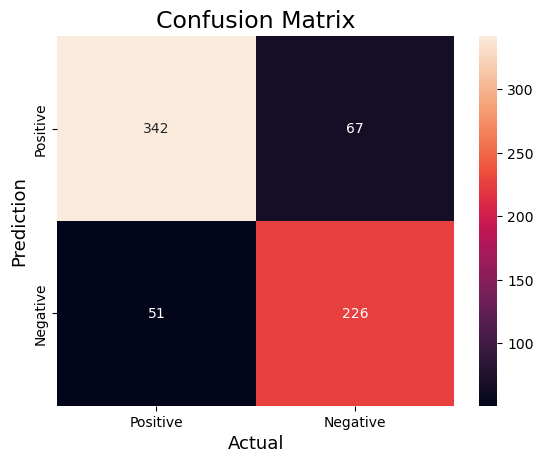

In [7]:
sns.heatmap(cm,
    annot=True,
    fmt='g',
    xticklabels=['Positive','Negative'],
    yticklabels=['Positive','Negative'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

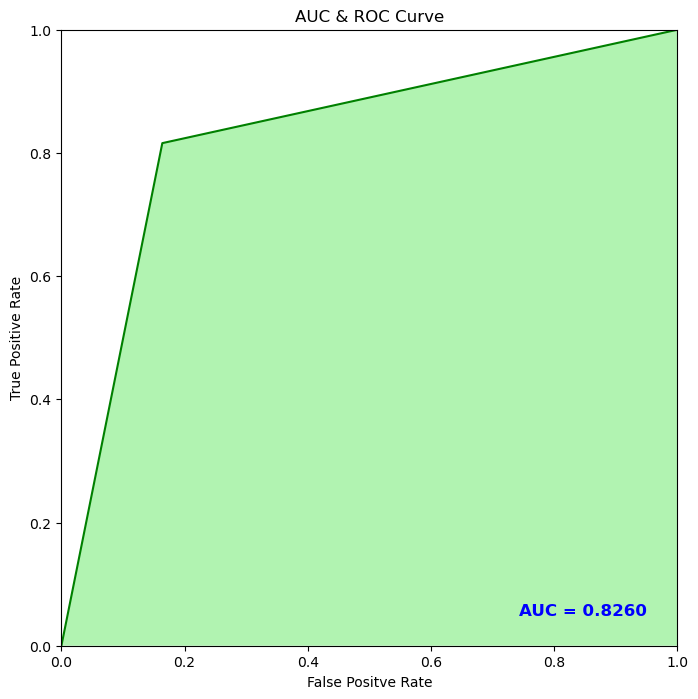

In [8]:
auc = roc_auc_score(tl1, pl1)

false_positive_rate, true_positive_rate, thresholds = roc_curve(tl1, pl1)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate")
plt.show()